# EDA 与 baseline 模型

In [530]:
import os
import pickle
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import polars as pl
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Objective

> The task of this competition is to **extract the atmospheric spectra from each observation, with an estimate of its level of uncertainty**. In order to obtain such a spectrum, we require the participant to detrend a large number of sequential 2D images of the spectral focal plane taken over several hours of observing the exoplanet as it eclipses its host star. Performing this detrending process to extract atmospheric spectra and their associated errorbars from raw observational data is a crucial and common prerequisite step for any modern astronomical instrument before the data can undergo scientific analysis.
>
> 此次竞赛的任务是从每次观测中提取大气光谱，并估计其不确定性水平。为了获得这样的光谱，我们要求参与者对在数小时内对系外行星凌日过程的观测中获取的大量连续二维光谱焦平面图像进行去趋势处理。从原始观测数据中通过这一去趋势过程提取大气光谱及其相关误差条是任何现代天文仪器进行科学分析之前的一个重要且常见的前提步骤。

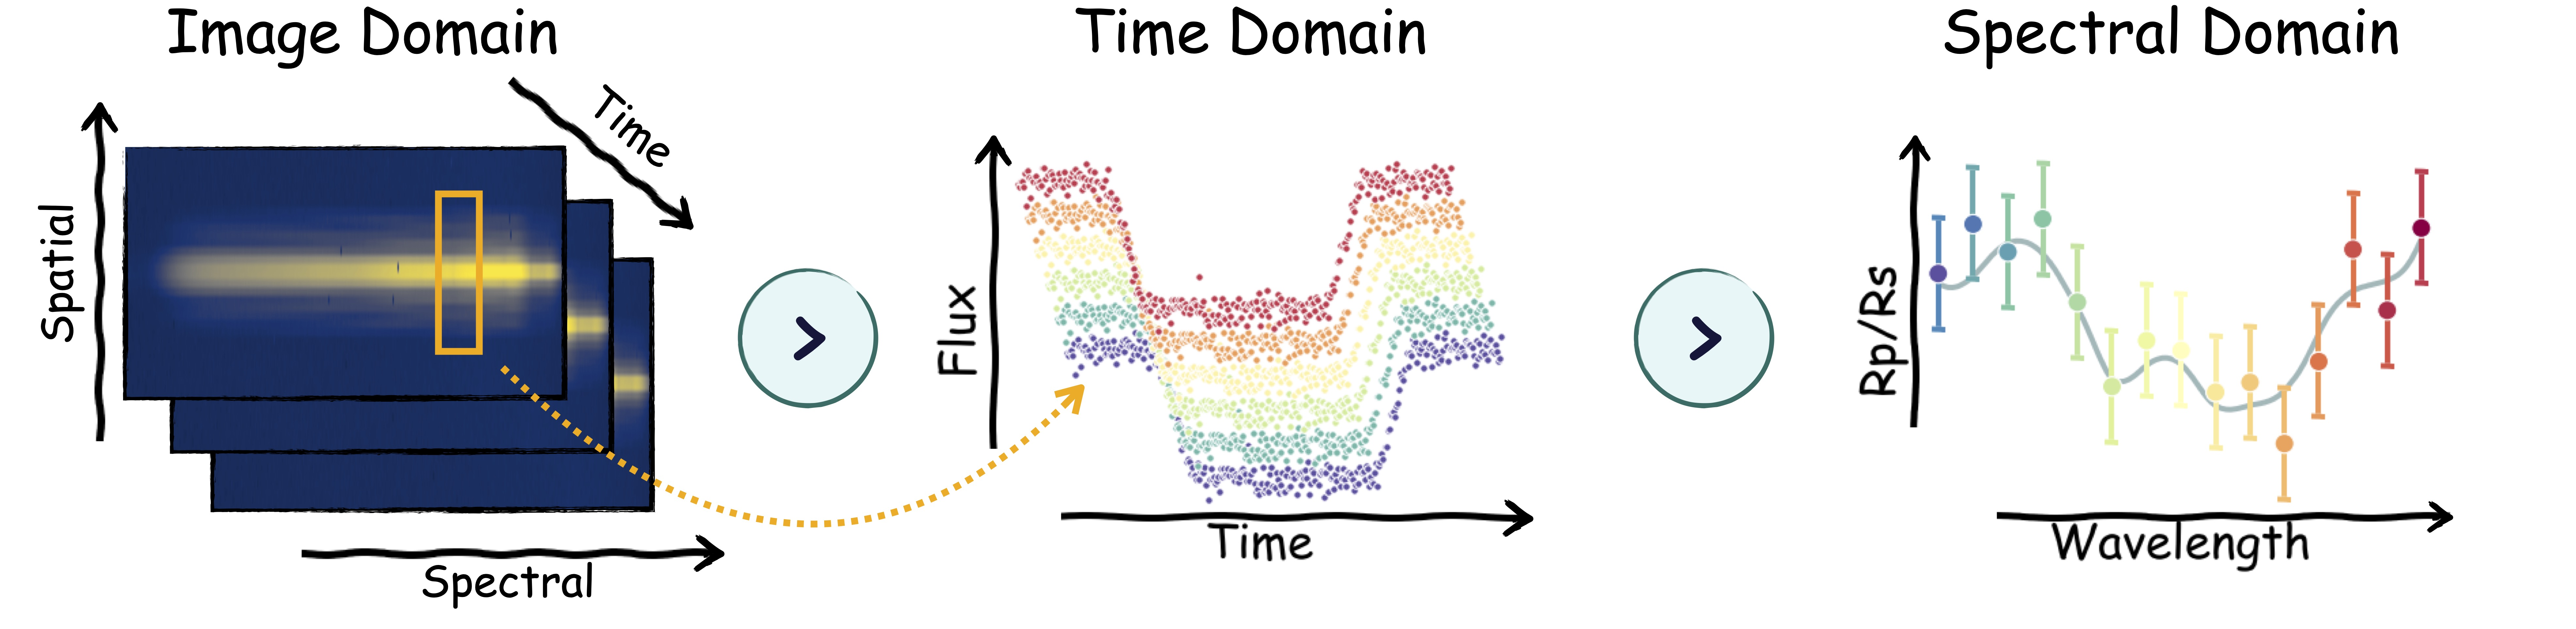

## EDA

### Meta

In [3]:
ls ../input

ariel-data-challenge-2024.zip  test/              train_adc_info.csv
axis_info.parquet              test_adc_info.csv  train_labels.csv
sample_submission.csv          train/             wavelengths.csv


#### train_adc_info

In [149]:
train_info_df = pd.read_csv('../input/train_adc_info.csv', index_col='planet_id')

In [150]:
train_info_df.head()

FGS1_adc_offset  FGS1_adc_gain  AIRS-CH0_adc_offset  \
planet_id                                                        
785834         -343.335938       0.837244          -778.916533   
14485303       -366.381992       0.842983          -740.323212   
17002355       -386.107037       1.041701          -808.690659   
24135240       -339.737490       0.840239          -776.124167   
25070640       -355.660433       1.041280          -848.371494   

           AIRS-CH0_adc_gain  star  
planet_id                           
785834              0.924746     1  
14485303            0.931727     1  
17002355            1.513541     0  
24135240            0.931277     1  
25070640            1.503923     0

In [5]:
train_info_df.shape[0]

673

In [151]:
train_info_df.star.value_counts()

star
0    346
1    327
Name: count, dtype: int64

训练集一共有673颗行星，来源于2个恒星系统。根据比赛方说明，测试集大约有800颗行星，来源于3个恒星系统，其中2个与测试集一样，另一个是测试集之外。
>This competition uses a hidden test set. When your submitted notebook is scored, the actual test data (including a full length sample submission) will be made available to your notebook. Expect to see **roughly 800 exoplanets in the hidden test set**.


> we have 3 planetary systems with stars ( 0, 1, 2 ) => train (0, 1) and test (0, 1, 2) ( 2 conformed, need to conform 0 or 1 or both with LB prob (详见: [CV Strategy [ New Star in test set - host conformed ]](https://www.kaggle.com/competitions/ariel-data-challenge-2024/discussion/524665))

#### train_labels

In [152]:
train_label_df = pd.read_csv('../input/train_labels.csv', index_col='planet_id')

In [153]:
train_label_df.shape[0]

673

In [236]:
star0_planets = train_info_df[train_info_df.star == 0].sample(4).index
star1_planets = train_info_df[train_info_df.star == 1].sample(4).index

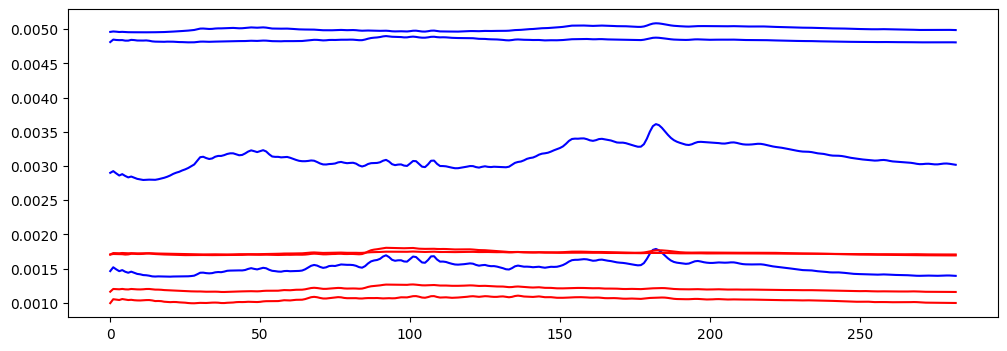

In [239]:
plt.figure(figsize=(12, 4))
for i, planet_id in enumerate(star0_planets, 1):
    plt.plot(train_label_df.loc[planet_id].values, color='blue')

for i, planet_id in enumerate(star1_planets, 5):
    plt.plot(train_label_df.loc[planet_id].values, color='red')

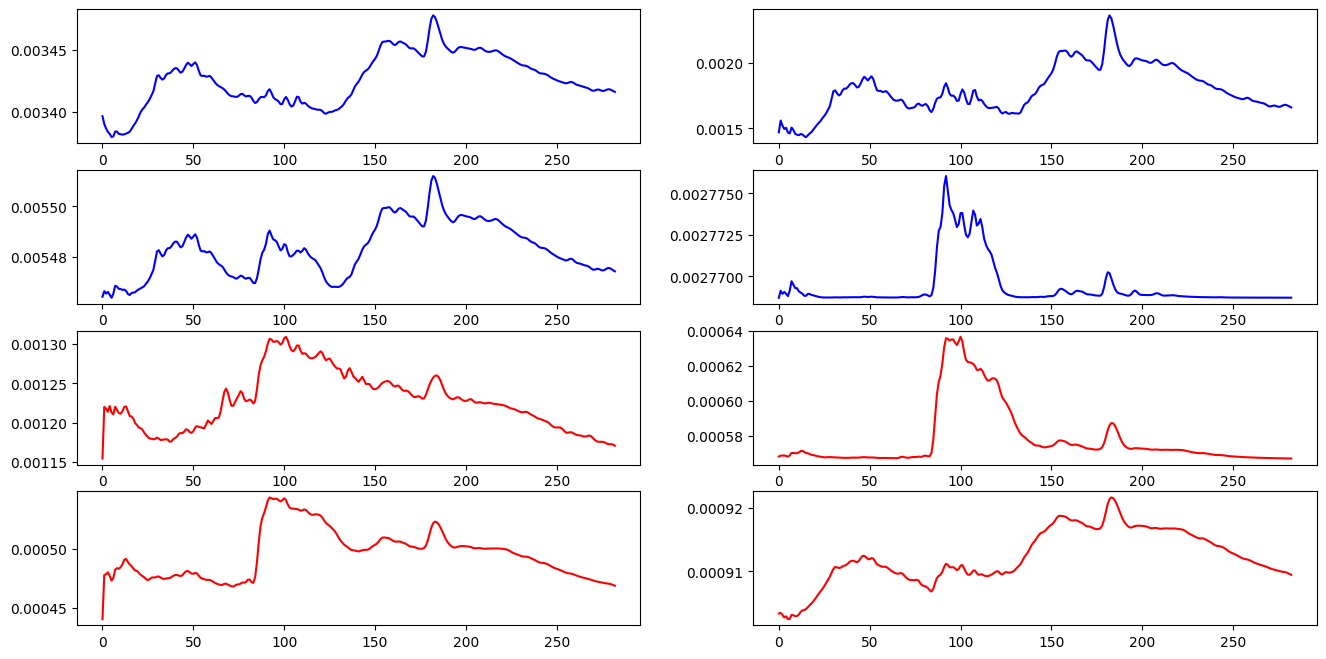

In [235]:
plt.figure(figsize=(16, 8))
for i, planet_id in enumerate(star0_planets, 1):
    plt.subplot(4, 2, i)
    plt.plot(train_label_df.loc[planet_id].values, color='blue')

for i, planet_id in enumerate(star1_planets, 5):
    plt.subplot(4, 2, i)
    plt.plot(train_label_df.loc[planet_id].values, color='red')

#### axis_info

In [240]:
axis_info_df = pd.read_parquet('../input/axis_info.parquet')

In [241]:
axis_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135000 entries, 0 to 134999
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   AIRS-CH0-axis0-h           11250 non-null   float64
 1   AIRS-CH0-axis2-um          356 non-null     float64
 2   AIRS-CH0-integration_time  11250 non-null   float64
 3   FGS1-axis0-h               135000 non-null  float64
dtypes: float64(4)
memory usage: 4.1 MB


- AIRS-CH0-axis2-um: um应该表示微米，猜测这里应该表示的波长。联想到 AIRS-CH0 产生的图像数据为 356x32，该列应该对应的是横轴的波长。
- AIRS-CH0-integration_time：交替出现 0.1 和 4.5 两个值
- AIRS-CH0-axis0-h/FGS1-axis0-h：曝光时间，总时长7.5h

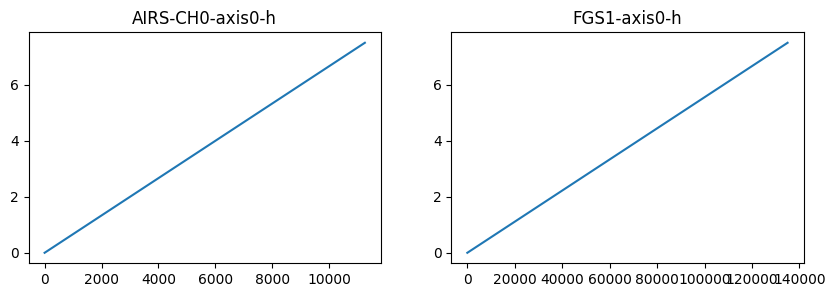

In [592]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(axis_info_df['AIRS-CH0-axis0-h'])
_ = plt.title('AIRS-CH0-axis0-h')

plt.subplot(1, 2, 2)
plt.plot(axis_info_df['FGS1-axis0-h'])
_ = plt.title('FGS1-axis0-h')


#### wavelengths

In [242]:
wavelengths = pd.read_csv('../input/wavelengths.csv')

In [243]:
wavelengths

wl_1      wl_2      wl_3     wl_4      wl_5      wl_6      wl_7      wl_8  \
0  0.705  1.951761  1.960612  1.96945  1.978273  1.987083  1.995879  2.004661   

      wl_9     wl_10  ...   wl_274   wl_275    wl_276   wl_277    wl_278  \
0  2.01343  2.022184  ...  3.84972  3.85481  3.859887  3.86495  3.869999   

     wl_279    wl_280    wl_281    wl_282    wl_283  
0  3.875034  3.880055  3.885063  3.890056  3.895036  

[1 rows x 283 columns]

- wl_1：FGS1探测波长，取值为0.705µm
- wl_2 ~ wl_283：AIRS-CH0探测波长，取值为1.95～3.90

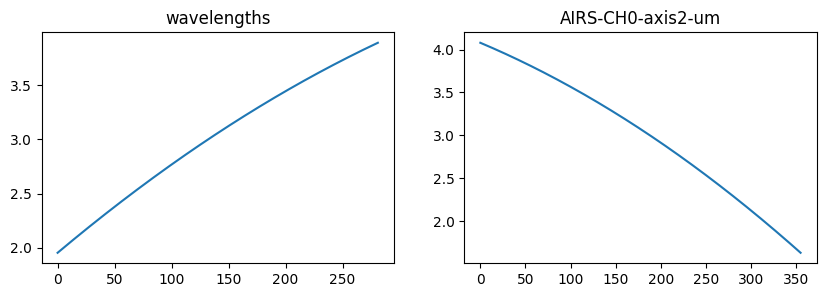

In [598]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(wavelengths.iloc[0].values[1:])
_ = plt.title('wavelengths')

plt.subplot(1, 2, 2)
plt.plot(axis_info_df['AIRS-CH0-axis2-um'].dropna())
_ = plt.title('AIRS-CH0-axis2-um')

### Signal

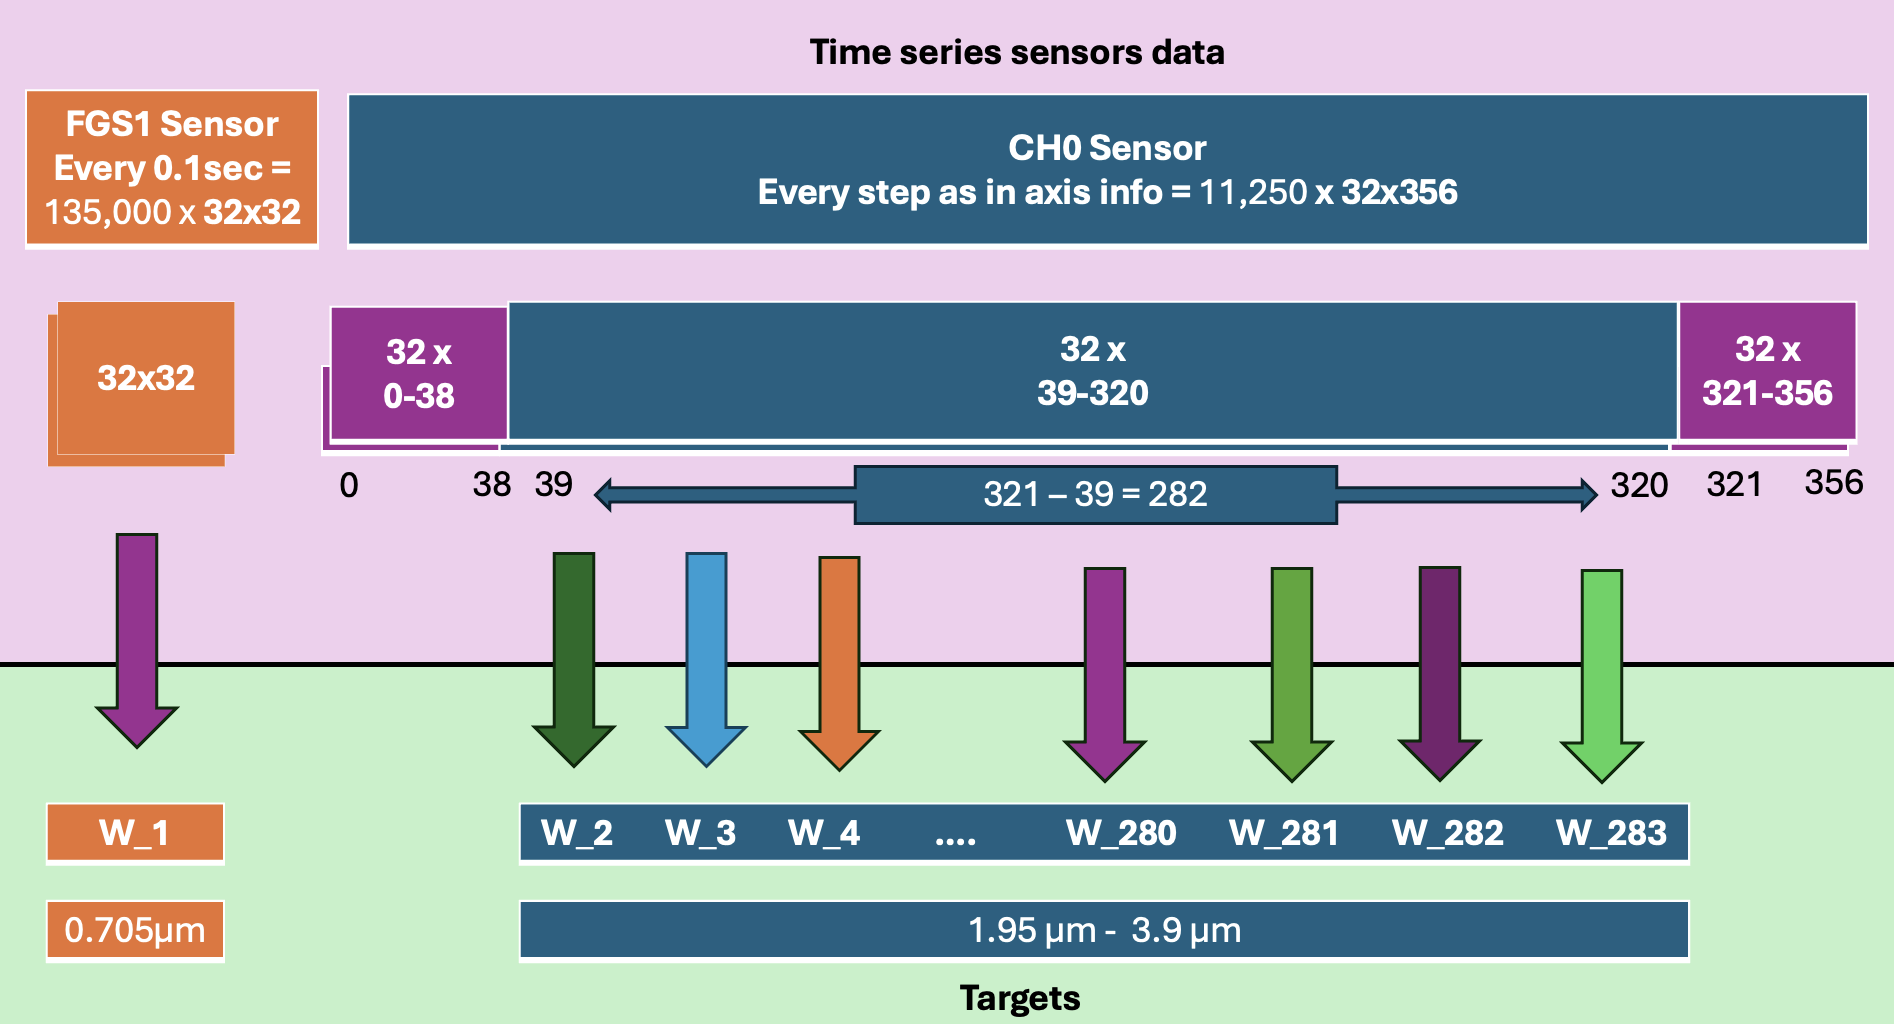

#### FGS1

In [534]:
planet_id = 100468857

In [535]:
f_signal = pl.read_parquet(f'../input/train/{planet_id}/FGS1_signal.parquet').cast(pl.Int32).to_numpy()

In [536]:
vmin = f_signal[:8].min()
vmax = f_signal[:8].max()

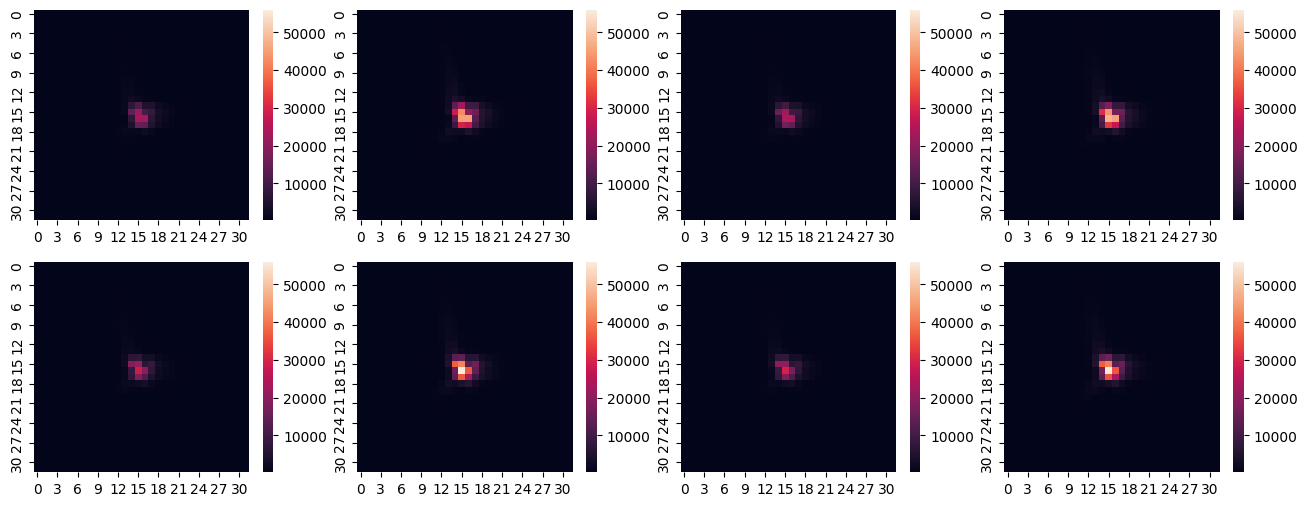

In [178]:
plt.figure(figsize=(16, 6))
for i in range(8):
    img = f_signal[i].reshape(32, 32)
    plt.subplot(2, 4, i+1)
    sns.heatmap(img, vmin=vmin, vmax=vmax)

In [180]:
f_signal[:8].mean(axis=-1)

array([574.96679688, 799.80664062, 575.47167969, 800.1328125 ,
       575.24414062, 800.56640625, 576.21289062, 801.72265625])

光通量(Flux)是震荡的，第二张比第一张信号要强，在比赛的数据介绍中也有提到：
>When examining frames from either instrument, you'll notice the flux levels oscillate between low and high counts. This is intentional and due to the design of the observing mode. Each pixel in the telescope's detector acts like a charge accumulator. The process begins with a sub-exposure recording the initial charge level before accumulation starts. After a set exposure time, another sub-exposure captures the new charge level. The pixels are then reset, and this cycle repeats for the duration of the observation. This allows for detailed temporal information to be captured. It's particularly useful for observing rapid changes, such as those occurring during a planetary transit. In this observation, the process generates 135,000 frames for FGS1 and 11,250 frames for AIRS-CH0.
>
>当检查任一仪器的帧时，您会注意到通量水平在低计数和高计数之间波动。这是有意设计的观测模式所致。望远镜探测器中的每个像素都像一个电荷积累器。过程首先从记录积累开始前的初始电荷水平的子曝光开始。经过设定的曝光时间后，另一个子曝光会捕捉新的电荷水平。然后像素被重置，这个循环在整个观测期间重复。这使得可以捕捉详细的时间信息。它特别适用于观测快速变化，例如在行星凌日过程中发生的变化。在这次观测中，此过程为FGS1生成了135,000帧，为AIRS-CH0生成了11,250帧。

In [216]:
f_signal_mean = f_signal.mean(axis=-1)

f_signal_mean_leading = f_signal_mean[0::2]
f_signal_mean_lagging = f_signal_mean[1::2]

f_signal_mean_diff = f_signal_mean_lagging - f_signal_mean_leading

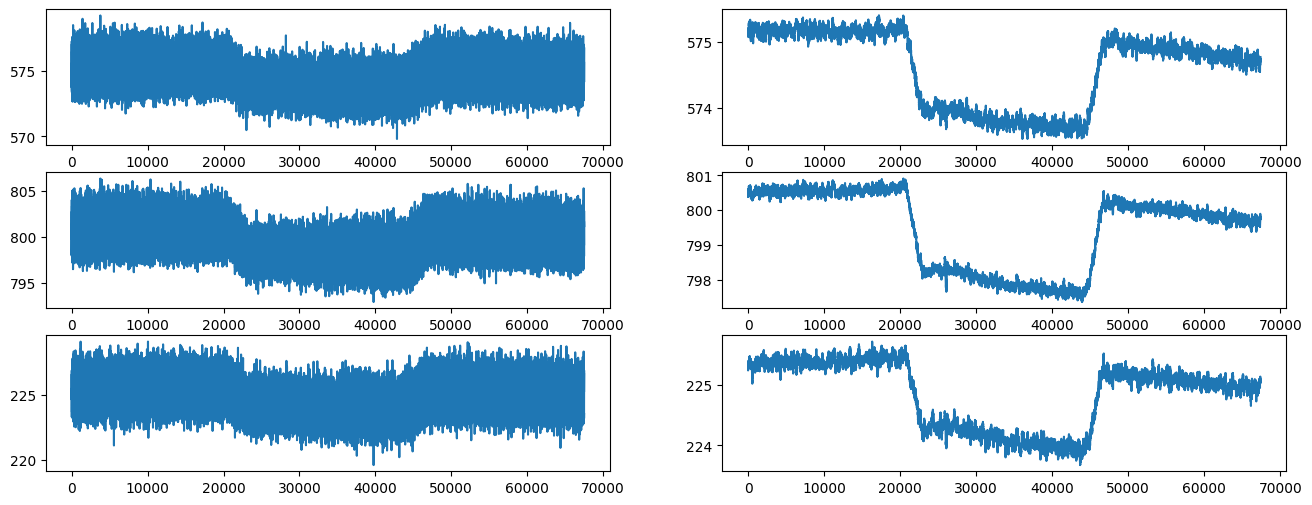

In [215]:
plt.figure(figsize=(16, 6))
for i, signal in enumerate([f_signal_mean_leading, f_signal_mean_lagging, f_signal_mean_diff]):
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(signal)
    
    cum_signal = signal.cumsum()
    window=100
    smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window
    plt.subplot(3, 2, 2*i + 2)
    plt.plot(smooth_signal)

#### AIRS-CH0

In [161]:
planet_id = 100468857

In [556]:
a_signal = pl.read_parquet(f'../input/train/{planet_id}/AIRS-CH0_signal.parquet').cast(pl.Int32).to_numpy()

In [558]:
vmin = a_signal[:8].min()
vmax = a_signal[:8].max()

In [559]:
vmin, vmax

(565, 63915)

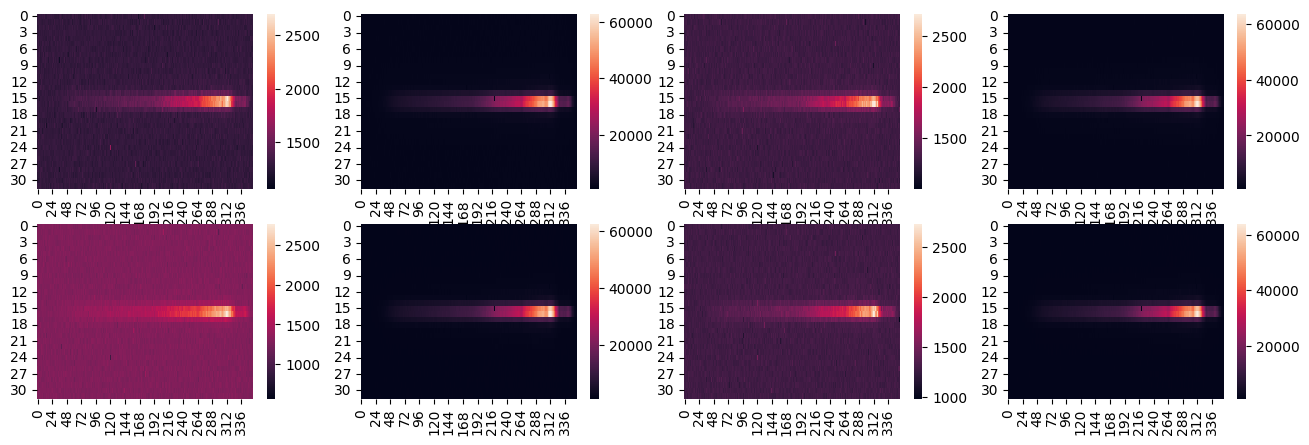

In [223]:
plt.figure(figsize=(16, 5))
for i in range(8):
    img = a_signal[i].reshape(32, 356)
    plt.subplot(2, 4, i+1)
    # sns.heatmap(img, vmin=vmin, vmax=vmax)
    sns.heatmap(img)

- 横轴：波长，取值数为356
- 纵轴：空间，取值数为32，解释：
> Originally, scientists only have irradiated pixels, with the only unit being pixels. To simplify the process of linking these pixels to the wavelength of the light, we simulated the detector so that the light always aligns with the pixel window and is dispersed in one direction, the x-axis. And this is why we provide the wavelength of the light hitting each pixel.
>Also, the signal is strongest at the center of the y-axis because we've aligned the signal to be dispersed horizontally, and the light from a point source is spread by the telescope optics, and typically it peaks at the center.

In [224]:
a_signal[:8].mean(axis=-1)

array([1313.16678371, 2662.86060393, 1312.92494733, 2662.37693118,
       1312.56925913, 2662.27835323, 1312.71374649, 2662.3511236 ])

In [225]:
a_signal_mean = a_signal.mean(axis=-1)

a_signal_mean_leading = a_signal_mean[0::2]
a_signal_mean_lagging = a_signal_mean[1::2]

a_signal_mean_diff = a_signal_mean_lagging - a_signal_mean_leading

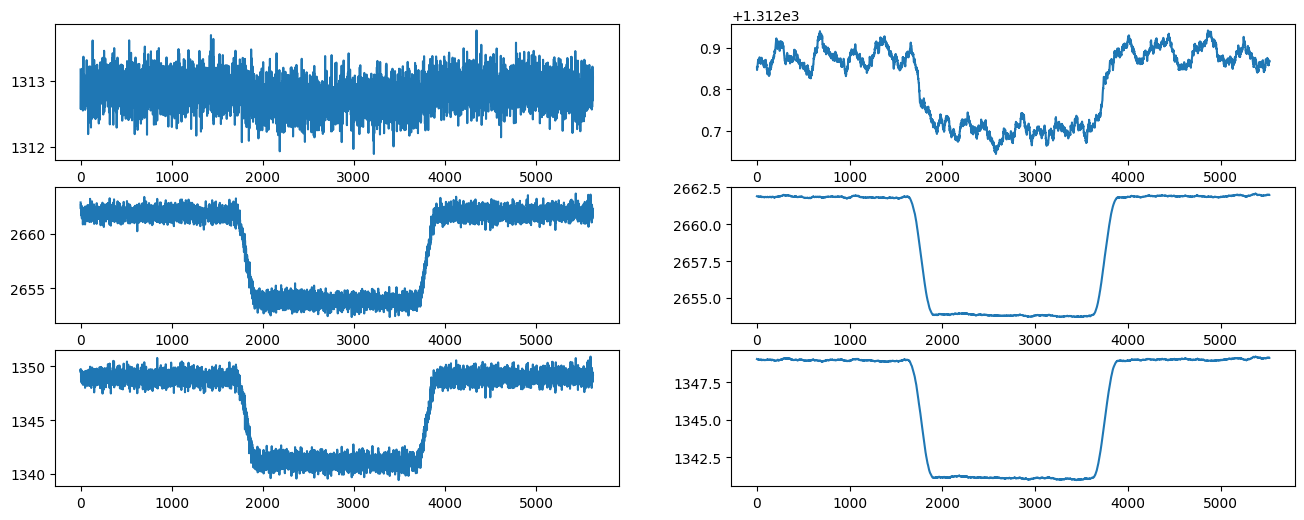

In [226]:
plt.figure(figsize=(16, 6))
for i, signal in enumerate([a_signal_mean_leading, a_signal_mean_lagging, a_signal_mean_diff]):
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(signal)
    
    cum_signal = signal.cumsum()
    window=100
    smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window
    plt.subplot(3, 2, 2*i + 2)
    plt.plot(smooth_signal)

## 简单时间序列建模

- AIRS-CH0 完整数据形式为：673 x 11250 x 32 x 356 (行星 x 时间 x 空间 x 波长)
- FGS1 完整数据形式为：673 x 135000 x 32 x 32 (行星 x 时间 x 长 x 宽)
- 监督学习的 label 为：673 x 283，属于 MultiOutputRegression 问题

直接用原始特征建模不太现实，需要对特征进行抽象、精简，即特征提取(这个过程会伴随信息的丢失)。做为baseline模型，我们尽量保持简单，按以下思路进行特征提取和建模：
- AIRS-CH0 包含了不同波长(356)的光通量随时间变化的信息(凌日期间 vs 凌日前后)，对每个波长，我们都得到描述变化的值，这样一共得到356个特征；
- FGS1 只有单个光通量随时间变化的信息，我们只抽取一个描述变化的值，这样只得到1个特征；
- 挑选一个支持 MultiOutputRegression 的模型，比如 ridge regression；
- 对于283个预测值，比赛方还要求给出不确定性估计(即标准差sigma)，可以考虑多模型预测，从而粗略估算每个预测值的标准差；

### 信号读入与预处理

由于 AIRS-CH0 和 FGS1 信号都是累加的形式，奇数帧和偶数帧曝光时间不同，有三种使用方式：
- 单独奇数列
- 单独偶数列
- 奇数列与偶数列求diff

我们这里采用第三种方式。

In [270]:
def a_read_and_preprocess(dataset, adc_info, planet_ids):
    '''读入 AIRS-CH0 信号，并提取时间序列

    参数:
    dataset: 'train' or 'test'
    adc_info: train_adc_info or test_adc_info
    planet_ids: list of planet ids

    返回:
    np.ndarray: 673 x 5625 x 356  (为每个行星生成一个长度为5625的时间序列，在每个时间点上，记录356个波长各自的光通量)
    '''
    a_raw_data = np.full((len(planet_ids), 5625, 356), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        signal = pl.read_parquet(f'../input/{dataset}/{planet_id}/AIRS-CH0_signal.parquet').cast(pl.Float32).to_numpy()
        signal = signal.reshape(11250, 32, 356)
        mean_signal = signal.mean(axis=1)  # 11250 x 356
        net_signal = mean_signal[1::2] - mean_signal[0::2]  # 5625 x 356
        a_raw_data[i] = net_signal
    return a_raw_data

In [289]:
a_raw_train = a_read_and_preprocess('train', train_info_df, train_info_df.index)

  0%|          | 0/673 [00:00<?, ?it/s]

In [304]:
a_raw_train.shape

(673, 5625, 356)

In [296]:
def f_read_and_preprocess(dataset, adc_info, planet_ids):
    '''读入 FGS1 信号，并提取时间序列

    参数:
    dataset: 'train' or 'test'
    adc_info: train_adc_info or test_adc_info
    planet_ids: list of planet ids

    返回:
    np.ndarray: 673 x 67500
    '''

    f_raw_data = np.full((len(planet_ids), 67500), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        signal = pl.read_parquet(f'../input/{dataset}/{planet_id}/FGS1_signal.parquet').cast(pl.Float32).to_numpy()  # 135000 x 1024
        mean_signal = signal.mean(axis=1)  # 135000 x
        net_signal = mean_signal[1::2] - mean_signal[0::2]  # 67500 x
        f_raw_data[i] = net_signal
    return f_raw_data

In [ ]:
f_raw_train = f_read_and_preprocess('train', train_info_df, train_info_df.index)

  0%|          | 0/673 [00:00<?, ?it/s]

In [305]:
f_raw_train.shape

(673, 67500)

In [ ]:
np.savez_compressed('ariel_trainset.npz', a_raw_train=a_raw_train, f_raw_train=f_raw_train, label=train_label_df.values)

### Feature engineering

这里要构造的特征是凌日时信号变暗了多少，首先需要判断凌日的起止时间，对于所有的星系/行星，凌日起止时间都一样吗？

In [376]:
def plot_transit(signal, annote_steps=None, window=100, color='blue'):
    cum_signal = signal.cumsum()
    smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window
    plt.plot(smooth_signal, color=color)
    if annote_steps:
        assert isinstance(annote_steps, list)
        for step in annote_steps:
            plt.axvline(step, color='gray')

In [364]:
sample_planets = train_info_df.groupby('star').sample(n=4)

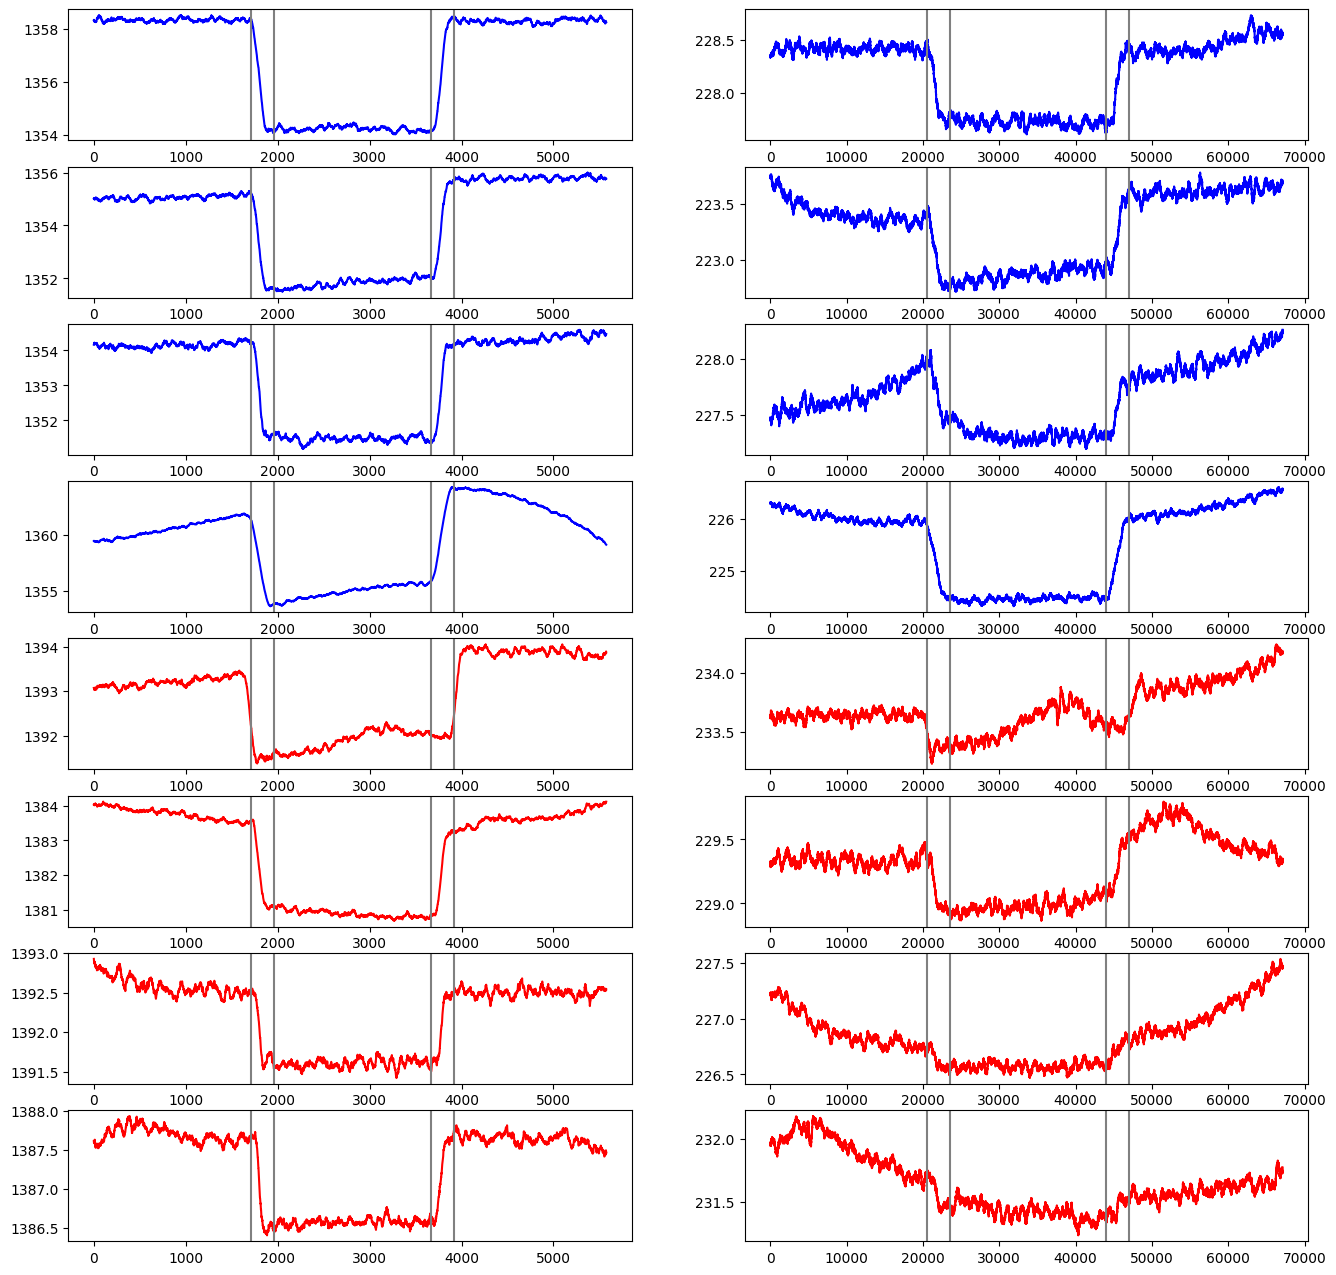

In [380]:
plt.figure(figsize=(16, 16))
for i, r in enumerate(sample_planets.itertuples()):
    idx = train_info_df.index.tolist().index(r.Index)
    a_signal = a_raw_train[idx].mean(axis=-1)
    f_signal = f_raw_train[idx]

    color = 'blue' if r.star == 0 else 'red'
    a_annote_steps = [1708, 1958, 3666, 3916]
    f_annote_steps = [20500, 23500, 44000, 47000]
    
    plt.subplot(8, 2, 2*i + 1)
    plot_transit(a_signal, a_annote_steps, window=50, color=color)
    
    plt.subplot(8, 2, 2*i + 2)
    plot_transit(f_signal, f_annote_steps, window=400, color=color)

看样子比赛方提供的数据大致是对齐的，各行星凌日的起止时间粗略看是一致的(也有例外，比如上图中的第5个行星 planet_id=2074140845)。为保持简单，在baseline模型中，我们认为它们有相同的凌日起止时间。

In [401]:
def feature_engineering(a_raw, f_raw):
    '''抽取特征，表征凌日时信号变暗了多少

    参数:
    a_raw: ndarray of shape (n_planets, 5625, 356)
    f_raw: ndarray of shape (n_planets, 67500)

    返回:
    ndarray of shape (n_planets, 356 + 1)
    '''
    obscured = a_raw[:, 1958:3666].mean(axis=1)
    unobscured = (a_raw[:, :1708].mean(axis=1) + a_raw[:, 3916:].mean(axis=1)) / 2
    a_relative_reduction = (unobscured - obscured) / unobscured  # 673 x 356
    
    obscured = f_raw[:, 23500:44000].mean(axis=1)
    unobscured = (f_raw[:, :20500].mean(axis=1) + f_raw[:, 47000:].mean(axis=1)) / 2
    f_relative_reduction = (unobscured - obscured) / unobscured

    res = np.hstack([a_relative_reduction, f_relative_reduction.reshape(-1, 1)])  # 673 x 357
    
    return res

In [402]:
X_train = feature_engineering(a_raw_train, f_raw_train)

In [405]:
Y_train = train_label_df.values

In [407]:
X_train.shape, Y_train.shape

((673, 357), (673, 283))

In [599]:
X_train = X_train.clip(0, None)

### 模型

In [416]:
from sklearn.linear_model import Ridge

In [417]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

X ~ Y 相关性：

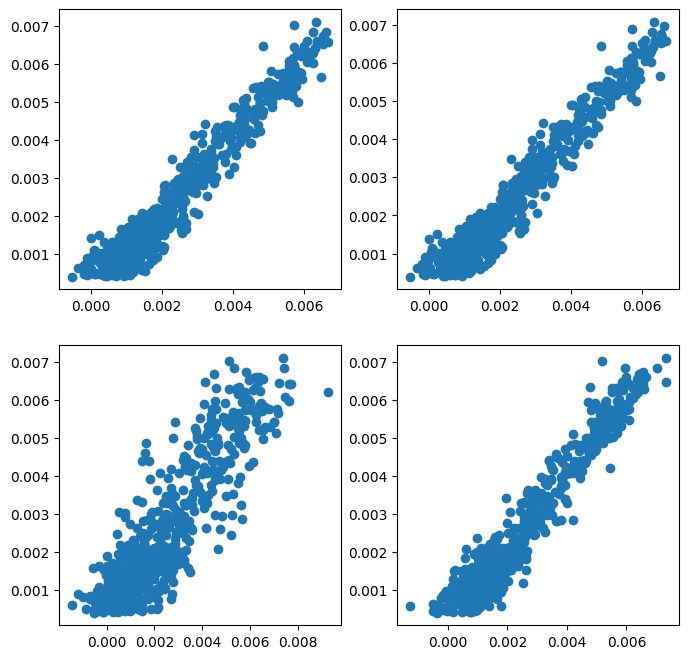

In [415]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.scatter(X_train[:, 312], Y_train[:, 0])

plt.subplot(2, 2, 2)
plt.scatter(X_train[:, 312], Y_train[:, 10])

plt.subplot(2, 2, 3)
plt.scatter(X_train[:, 40], Y_train[:, 0])

plt.subplot(2, 2, 4)
plt.scatter(X_train[:, 356], Y_train[:, 0])

### Ridge

In [600]:
model = sklearn.linear_model.Ridge(alpha=1e-12)

In [601]:
oof_pred = cross_val_predict(model, X_train, Y_train)

In [602]:
r2_score(Y_train, oof_pred)

0.9626048494114885

In [603]:
sigma_pred = mean_squared_error(Y_train, oof_pred, squared=False)

In [604]:
sigma_pred

0.0003337291638324614

In [605]:
def postprocessing(pred_array, index, sigma_pred):
    """Create a submission dataframe from its components
    
    Parameters:
    pred_array: ndarray of shape (n_samples, 283)
    index: pandas.Index of length n_samples with name 'planet_id'
    sigma_pred: float
    
    Return value:
    df: DataFrame of shape (n_samples, 566) with planet_id as index
    """
    return pd.concat([pd.DataFrame(pred_array.clip(0, None), index=index, columns=wavelengths.columns),
                      pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i}" for i in range(1, 284)])],
                     axis=1)

# Adapted from https://www.kaggle.com/code/metric/ariel-gaussian-log-likelihood
class ParticipantVisibleError(Exception):
    pass

def competition_score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        naive_mean: float,
        naive_sigma: float,
        sigma_true: float,
        row_id_column_name='planet_id',
    ) -> float:
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths*2:
        raise ParticipantVisibleError('Wrong number of columns in the submission')

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None)
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))

In [606]:
oof_df = postprocessing(oof_pred, train_info_df.index, sigma_pred)

In [607]:
gll_score = competition_score(train_label_df.reset_index(),
                              oof_df.reset_index(),
                              naive_mean=train_label_df.values.mean(),
                              naive_sigma=train_label_df.values.std(),
                              sigma_true=0.000003)
print(f"# Estimated competition score: {gll_score:.3f}")

# Estimated competition score: 0.240
